In [1]:
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import dask
dask.config.set(scheduler='synchronous')
#from dask.distributed import Client, LocalCluster
#cluster = LocalCluster(processes=True)
#client = Client(cluster)  # memory_limit='16GB', 

import xarray as xr
from dask.diagnostics import ProgressBar

In [2]:
import sys
print(sys.executable)

/home/srvx11/lehre/users/a1303583/.conda/envs/ml_flood/bin/python3


In [3]:
def shift_time(ds, value):
    ds.coords['time'].values = pd.to_datetime(ds.coords['time'].values) + value
    return ds

# select data

In [57]:
static = xr.open_dataset('../data/danube/era5_slt_z_slor_lsm_stationary_field.nc')
print(static)
glofas = xr.open_dataset('../data/danube/glofas_reanalysis_danube_1981-2002.nc')
glofas = glofas.rename({'lat': 'latitude', 'lon': 'longitude'})  # to have the same name like in era5
glofas = shift_time(glofas, -dt.timedelta(days=1))
z_glofas = static['z'].isel(time=0)/9.81  # converting to m approx.
z_glofas = z_glofas.interp(latitude=glofas.latitude,
                           longitude=glofas.longitude)
print(z_glofas)
dis = glofas['dis']
print(dis)

<xarray.Dataset>
Dimensions:    (latitude: 13, longitude: 53, time: 31)
Coordinates:
  * longitude  (longitude) float32 7.0 7.25 7.5 7.75 ... 19.25 19.5 19.75 20.0
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... 47.5 47.25 47.0
  * time       (time) datetime64[ns] 2000-01-01T23:00:00 ... 2000-01-31T23:00:00
Data variables:
    slt        (time, latitude, longitude) float32 ...
    z          (time, latitude, longitude) float32 ...
    slor       (time, latitude, longitude) float32 ...
    lsm        (time, latitude, longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.6.4rc4 (http://code.zmaw.d...
    Conventions:  CF-1.6
    history:      Thu May 30 01:39:36 2019: cdo dayavg /home/srvx11/lehre/use...
    CDO:          Climate Data Operators version 1.6.4rc7 (http://code.zmaw.d...

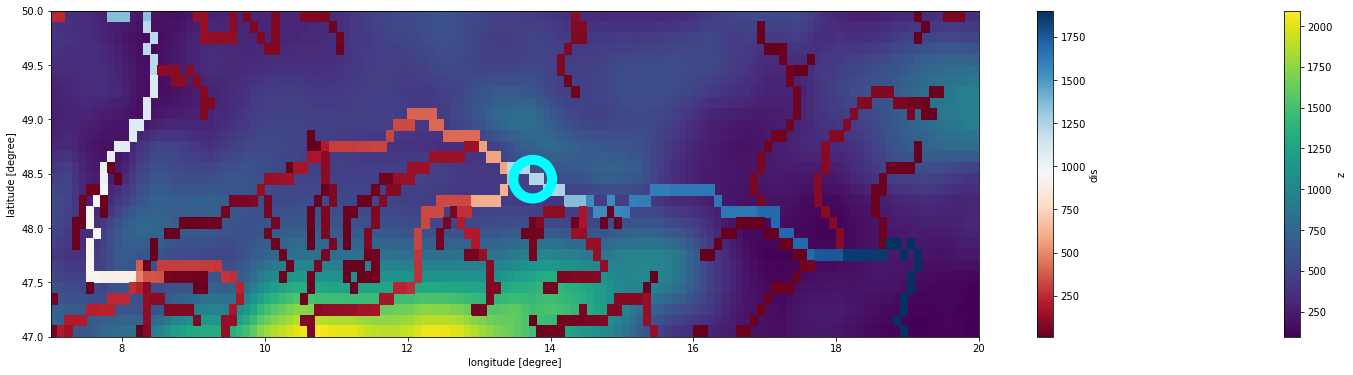

In [65]:
plt.figure(figsize=(26,6))
i = 48.45
j = 13.75
z_point = z_glofas.sel(latitude=slice(i, i-0.01)).sel(longitude=slice(j, j+0.01))

z_glofas.plot()

# river mask
river = dis.min('time') > 5
river.name = 'river mask [0/1]'
dis.mean('time').where(river).plot(cmap='RdBu')
#dis.mean('time').plot(cmap='RdBu')

ax = plt.gca()
p = plt.scatter(j, i, s=1500, marker='o', lw=10, facecolor='none', color='cyan')




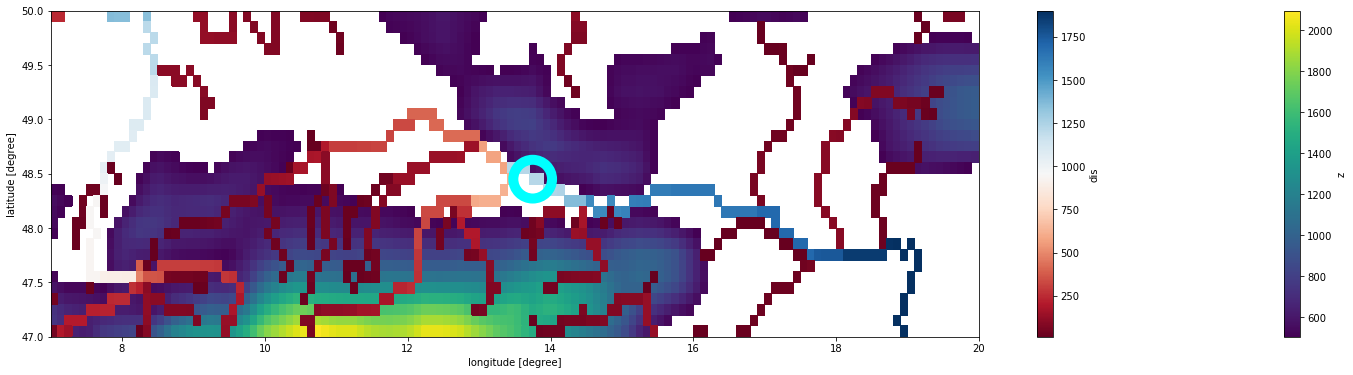

In [81]:
plt.figure(figsize=(26,6))
i = 48.45
j = 13.75
z_point = z_glofas.sel(latitude=slice(i, i-0.01)).sel(longitude=slice(j, j+0.01))

z_glofas.where(z_glofas.values >= z_point.values).plot()
dis.mean('time').where(river).plot(cmap='RdBu')

ax = plt.gca()
p = plt.scatter(j, i, s=1500, marker='o', lw=10, facecolor='none', color='cyan')

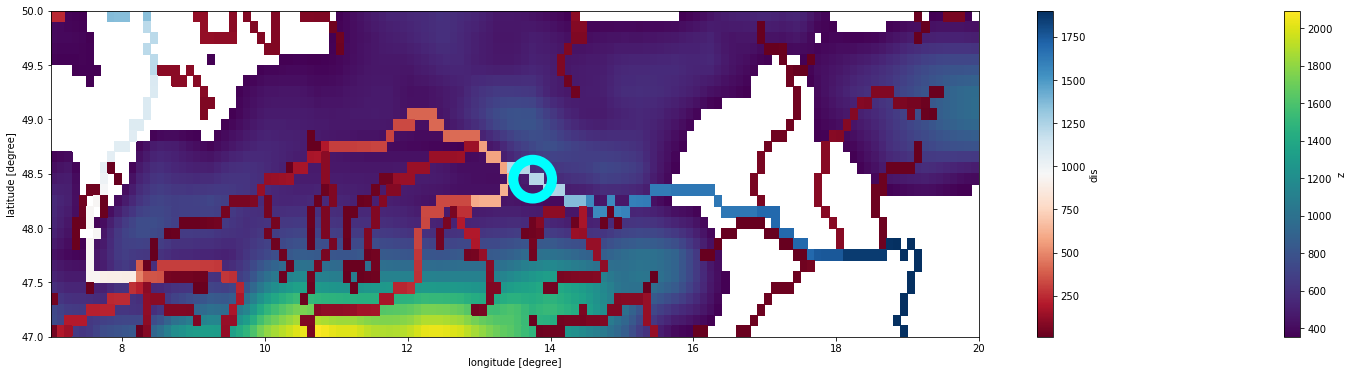

In [102]:
plt.figure(figsize=(26,6))
i = 48.45
j = 13.75
z_point = z_glofas.sel(latitude=slice(i, i-0.01)).sel(longitude=slice(j, j+0.01))

z_glofas.where(z_glofas.values >= z_point.values-150).plot()
dis.mean('time').where(river).plot(cmap='RdBu')

ax = plt.gca()
p = plt.scatter(j, i, s=1500, marker='o', lw=10, facecolor='none', color='cyan')

In [252]:
dis_point = dis.where(z_point).squeeze()
dis_point

<xarray.DataArray 'dis' (time: 8035)>
array([ 795.35077,  789.1969 ,  794.1277 , ..., 1835.7963 , 1871.4622 ,
       1876.7252 ], dtype=float32)
Coordinates:
    latitude   float64 48.45
    longitude  float64 13.75
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2002-12-31
Attributes:
    long_name:  discharge
    units:      m3/s

In [255]:
def correlate(da_3d, da_timeseries, timelag=False):
    a = da_3d - da_3d.mean('time')
    b = da_timeseries - da_timeseries.mean('time')
    N = len(b.coords['time'])
    if timelag:
        b = b.drop('time')
        a = a.drop('time')
#    out = b.dot(a)/a.std('time')/b.std()/N
    out = np.zeros(a.isel(time=1).shape)*np.nan
    i = 0
    for lat in a.latitude:
        j = 0
        for lon in a.longitude:
            a_iter = a.sel(latitude=lat, longitude=lon)
            out[i,j] = np.corrcoef(a_iter, b)[0,1]
            j += 1
        i += 1
    out = xr.DataArray(out, dims=['latitude', 'longitude'], coords=[a.latitude, a.longitude])
    out.name = 'correlation coefficient'
    return out

<xarray.DataArray 'correlation coefficient' (latitude: 30, longitude: 130)>
array([[0.114651, 0.114903,      nan, ..., 0.280584,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       ...,
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan, 0.746757, ...,      nan,      nan,      nan],
       [0.386606, 0.738376, 0.727296, ...,      nan,      nan,      nan]])
Coordinates:
  * latitude   (latitude) float64 49.95 49.85 49.75 49.65 ... 47.25 47.15 47.05
  * longitude  (longitude) float64 7.05 7.15 7.25 7.35 ... 19.75 19.85 19.95


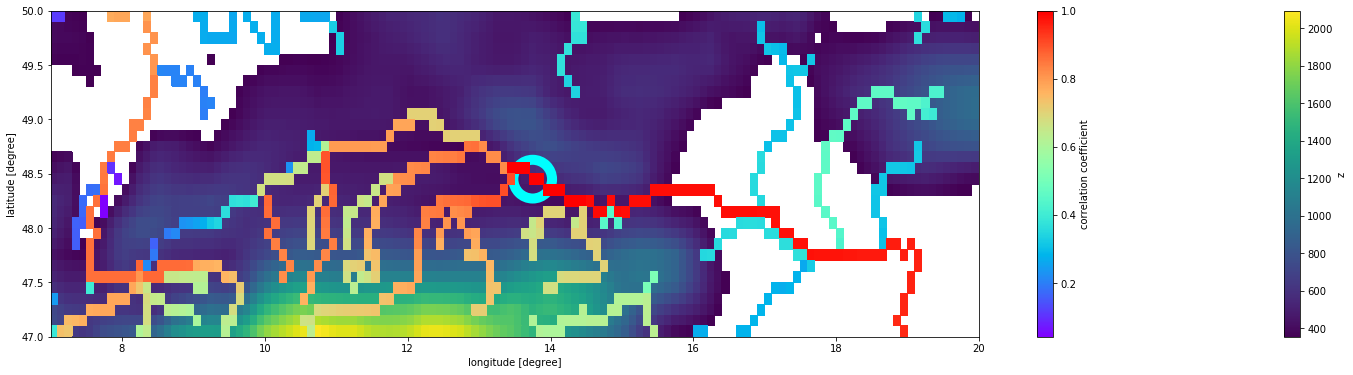

In [254]:
plt.figure(figsize=(26,6))
i = 48.45
j = 13.75
z_point = z_glofas.sel(latitude=slice(i, i-0.01)).sel(longitude=slice(j, j+0.01))

z_glofas.where(z_glofas.values >= z_point.values-150).plot()
#dis.mean('time').where(river).plot(cmap='RdBu')

ax = plt.gca()
p = plt.scatter(j, i, s=1500, marker='o', lw=10, facecolor='none', color='cyan')


a = correlate(dis.where(river), dis_point)
a.plot(cmap='rainbow')


In [342]:
def correlate(da_3d, da_timeseries, timelag=False):
    a = da_3d - da_3d.mean('time')
#    a = da_3d
    b = da_timeseries - da_timeseries.mean('time')
#    b = da_timeseries
    N = len(b.coords['time'])
    if timelag:
        b = b.drop('time')
        a = a.drop('time')
#    out = b.dot(a)/a.std('time')/b.std()/N
    out = np.zeros(a.isel(time=1).shape)*np.nan
    i = 0
    for lat in a.latitude:
        j = 0
        for lon in a.longitude:
            a_iter = a.sel(latitude=lat, longitude=lon)
            out[i,j] = np.corrcoef(a_iter, b)[0,1]
            j += 1
        i += 1
    out = xr.DataArray(out, dims=['latitude', 'longitude'], coords=[a.latitude, a.longitude])
    out.name = 'correlation coefficient'
    return out

In [348]:
lags = [-1, 1]

timelag_corrs = np.full((len(lags), dis.latitude.shape[0], dis.longitude.shape[0]), np.nan)
for t, lag in enumerate(lags):
    if lag > 0:  # dis_box with data from previous timesteps
        dis_point_lag = dis.where(z_point).squeeze()[lag:]
        dis_box = dis.where(river)[:-lag]
    elif lag < 0:  # dis_box with data from future timesteps
        dis_point_lag = dis.where(z_point).squeeze()[:lag]
        dis_box = dis.where(river)[-lag:]
        
    timelag_corrs[t,:,:] = correlate(dis_box, dis_point_lag, timelag=True)


lag_influencing = timelag_corrs[1,:,:] > timelag_corrs[0,:,:]

/home/srvx11/lehre/users/a1303583/.conda/envs/ml_flood/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


/home/srvx11/lehre/users/a1303583/.conda/envs/ml_flood/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]
/home/srvx11/lehre/users/a1303583/.conda/envs/ml_flood/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less


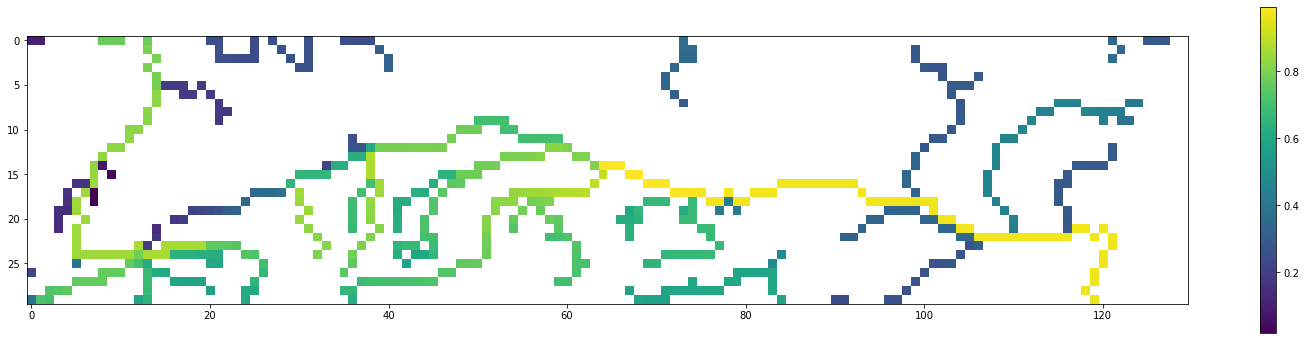

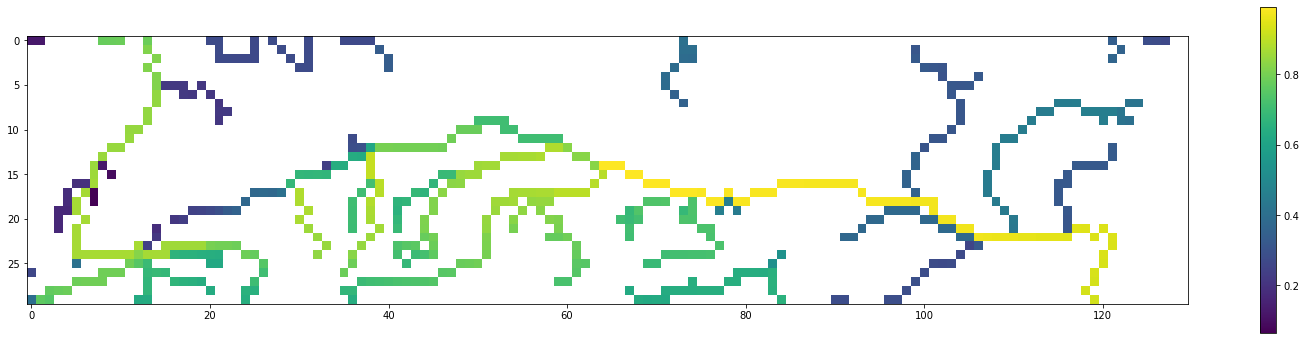

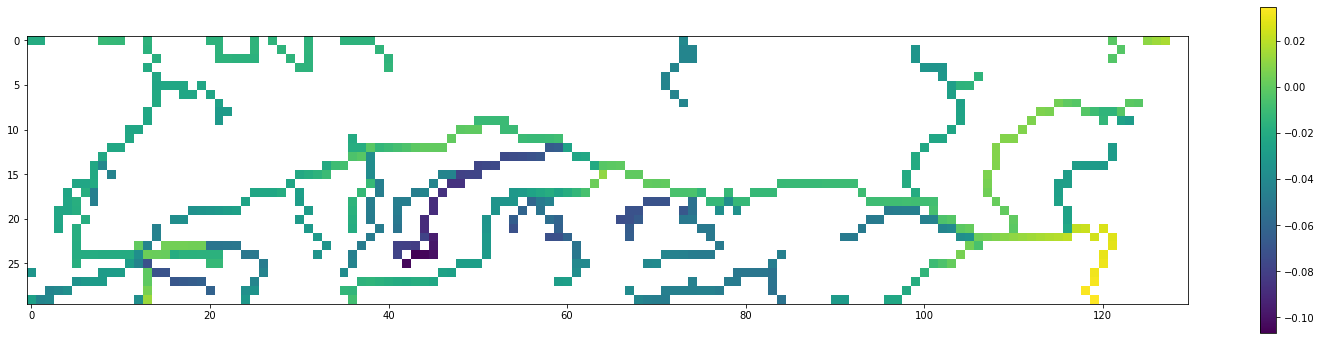

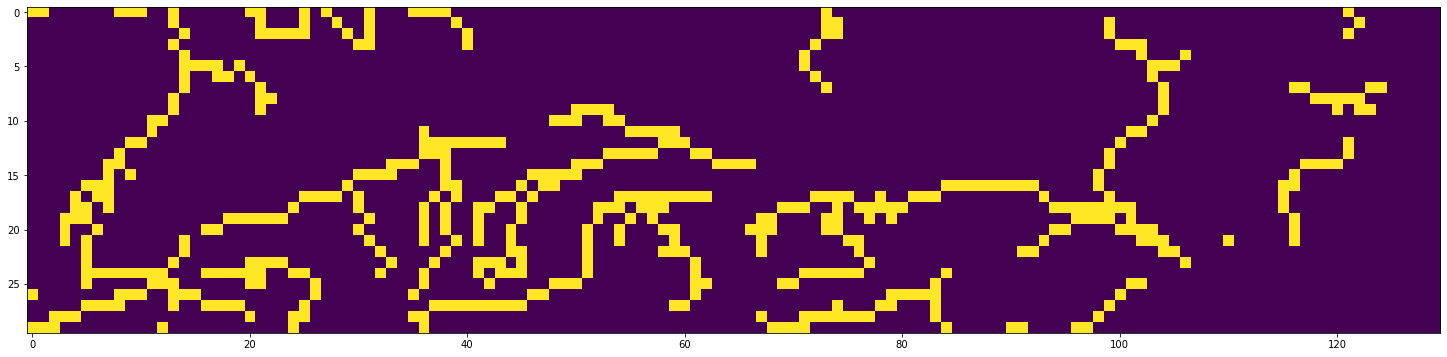

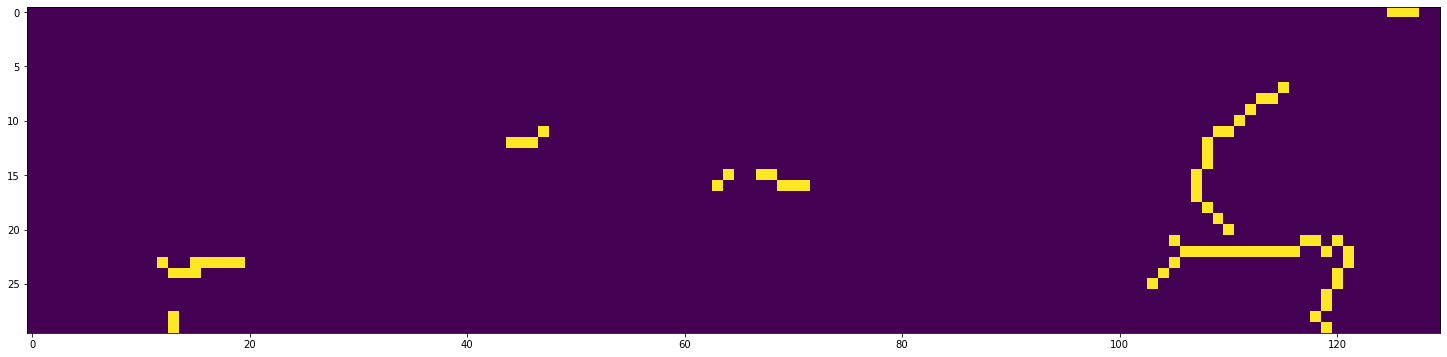

In [351]:
plt.figure(figsize=(26,6))
plt.imshow(timelag_corrs[0,:,:])
plt.colorbar()

plt.figure(figsize=(26,6))
plt.imshow(timelag_corrs[1,:,:])
plt.colorbar()

plt.figure(figsize=(26,6))
plt.imshow(timelag_corrs[0,:,:] - timelag_corrs[1,:,:])
plt.colorbar()

lag_influencing = timelag_corrs[1,:,:] > timelag_corrs[0,:,:]
plt.figure(figsize=(26,6))
plt.imshow(lag_influencing)

lag_influencing = timelag_corrs[1,:,:] < timelag_corrs[0,:,:]
plt.figure(figsize=(26,6))
plt.imshow(lag_influencing)

In [349]:
lag_influencing

array([[ True,  True, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])

# investigate single constraints

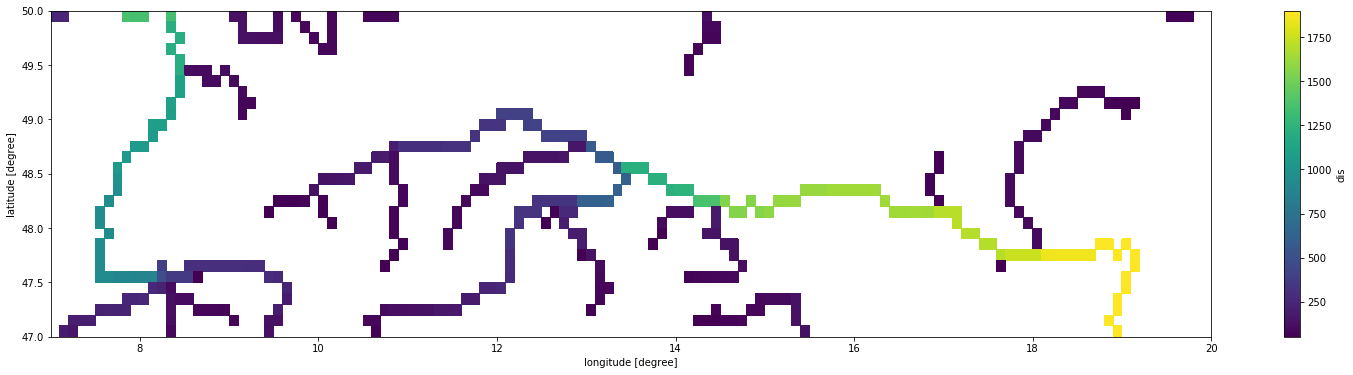

In [313]:
plt.figure(figsize=(26,6))
dis_box_mean = dis.mean('time')
dis_box_mean.where(dis_box_mean > 50).plot()

mask_box_mean_greater = (~np.isnan(dis_box_mean.where(dis_box_mean > 50))).astype(bool)

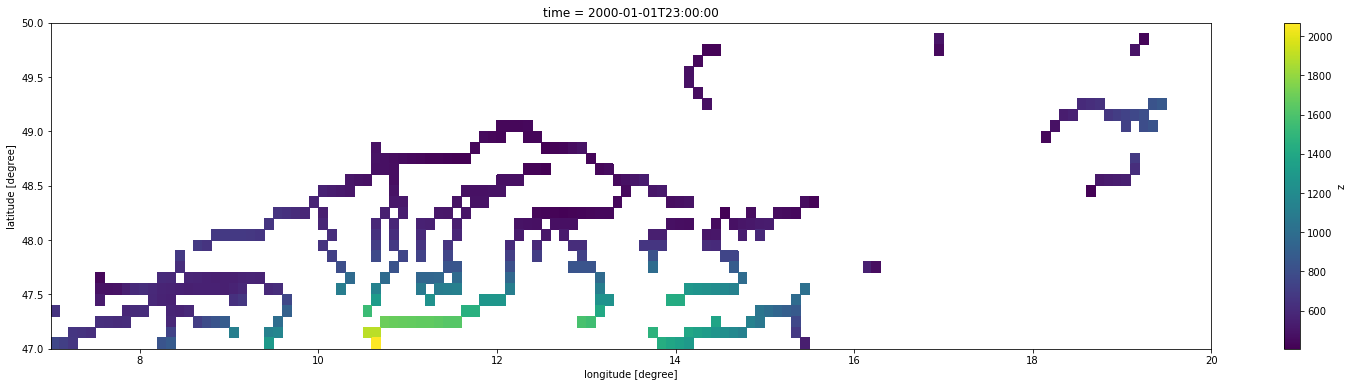

In [315]:
plt.figure(figsize=(26,6))
z_river = z_glofas.where(river)
z_river.where(z_river > z_point.squeeze()-100).plot()

mask_river_altitude_greater = (~np.isnan(z_river.where(z_river > z_point.squeeze()-100))).astype(bool)

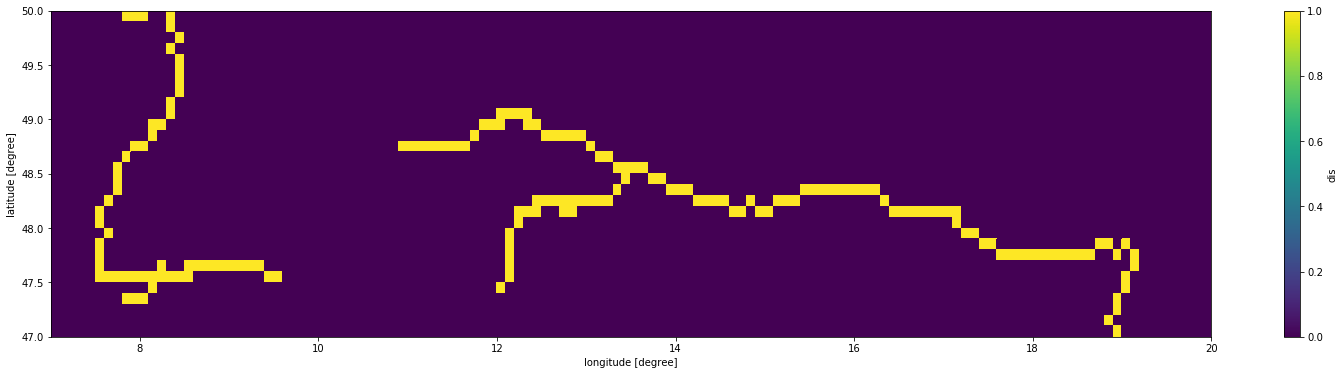

In [300]:
plt.figure(figsize=(26,6))
(dis_box_mean > pct*dis_box_mean.sel(latitude=dis_point.latitude, longitude=dis_point.longitude)).plot()

mask_mean_greater_pct_point = (dis_box_mean > pct*dis_box_mean.sel(latitude=dis_point.latitude, longitude=dis_point.longitude)).astype(bool)

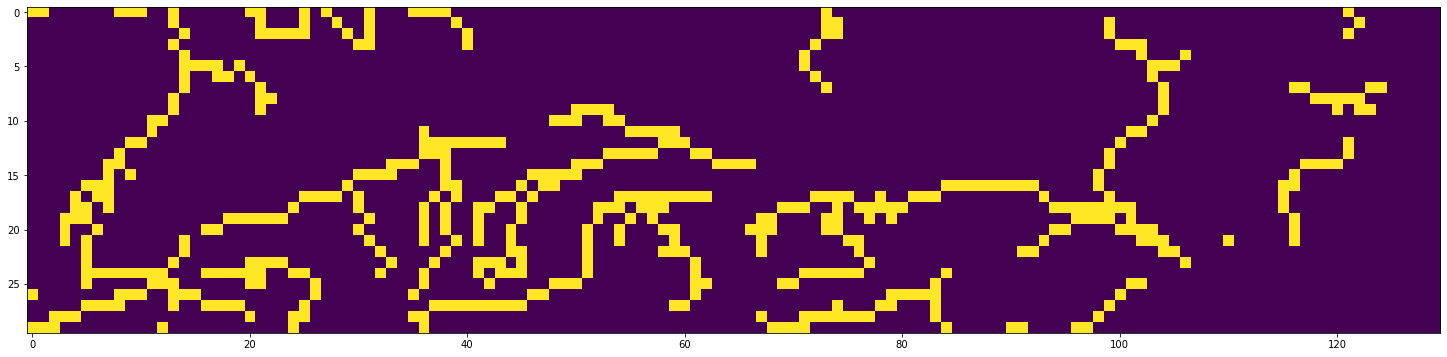

In [323]:
plt.figure(figsize=(26,6))
plt.imshow(lag_influencing > 0.9)

mask_lag_greater = (lag_influencing > 0.9).astype(bool)

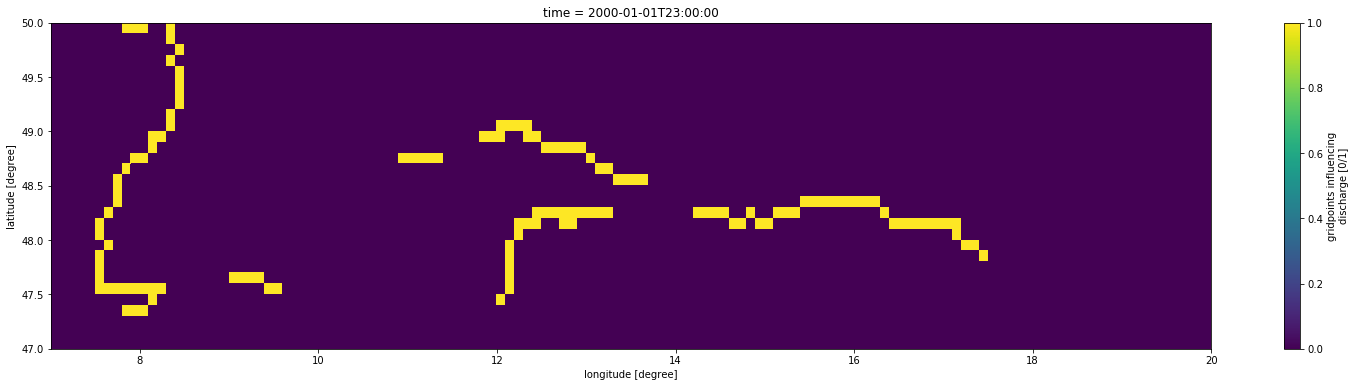

In [296]:
pct = 0.2
# select feature gridpoints
plt.figure(figsize=(26,6))
influencer = (dis_box_mean > pct*dis_box_mean.sel(latitude=dis_point.latitude, longitude=dis_point.longitude))  \
                &(river==1) & (lag_influencing > 0.5) \
                &(z_glofas.where(z_glofas >= z_point.squeeze()-50)).astype(bool)
               
influencer.name = 'gridpoints influencing discharge [0/1]'
influencer.plot()

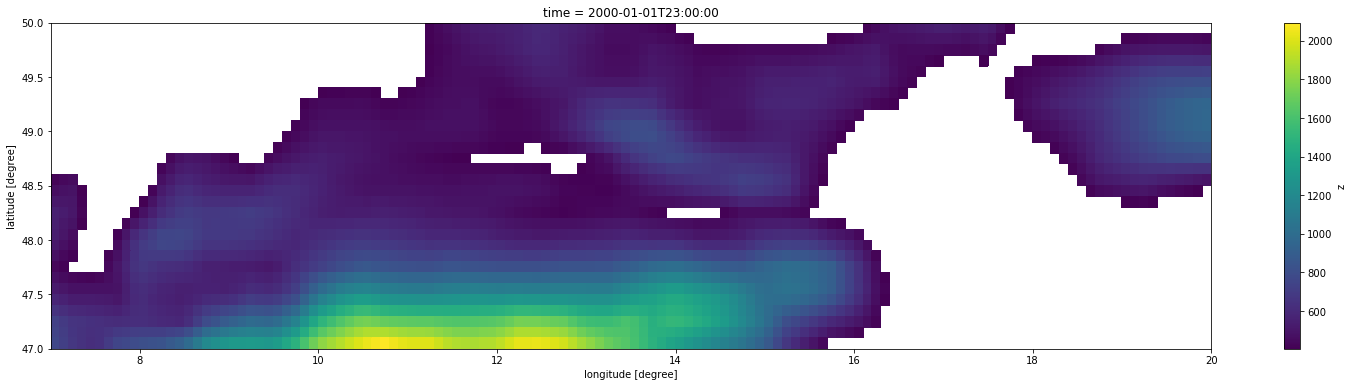

In [310]:
plt.figure(figsize=(26,6))
z_glofas.where(z_glofas > z_point.squeeze()-100).plot()

mask_z_greater = (~np.isnan(z_glofas.where(z_glofas > z_point.squeeze()-100))).astype(bool)

In [319]:
mask_box_mean_greater
mask_river_altitude_greater
mask_mean_greater_pct_point
mask_lag_greater
mask_z_greater

<xarray.DataArray 'z' (latitude: 30, longitude: 130)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])
Coordinates:
    time       datetime64[ns] 2000-01-01T23:00:00
  * latitude   (latitude) float64 49.95 49.85 49.75 49.65 ... 47.25 47.15 47.05
  * longitude  (longitude) float64 7.05 7.15 7.25 7.35 ... 19.75 19.85 19.95

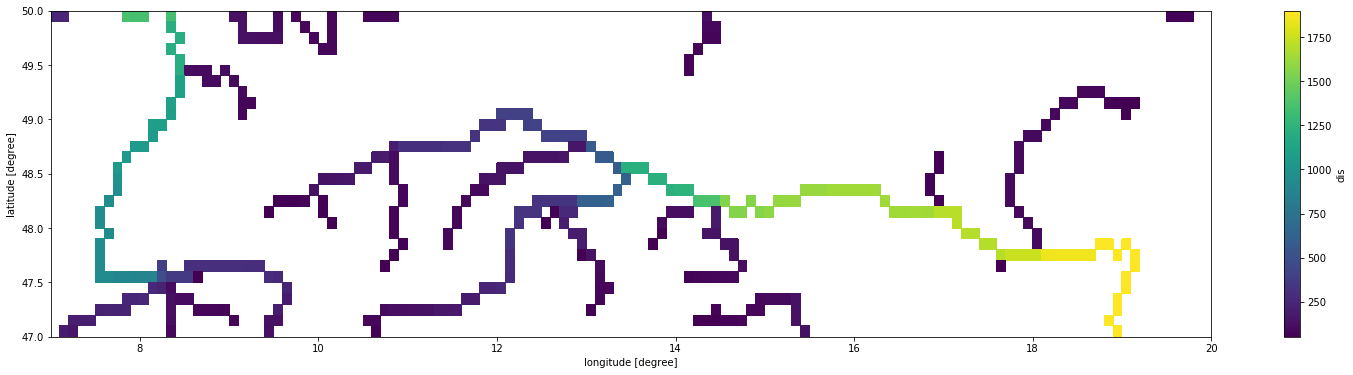

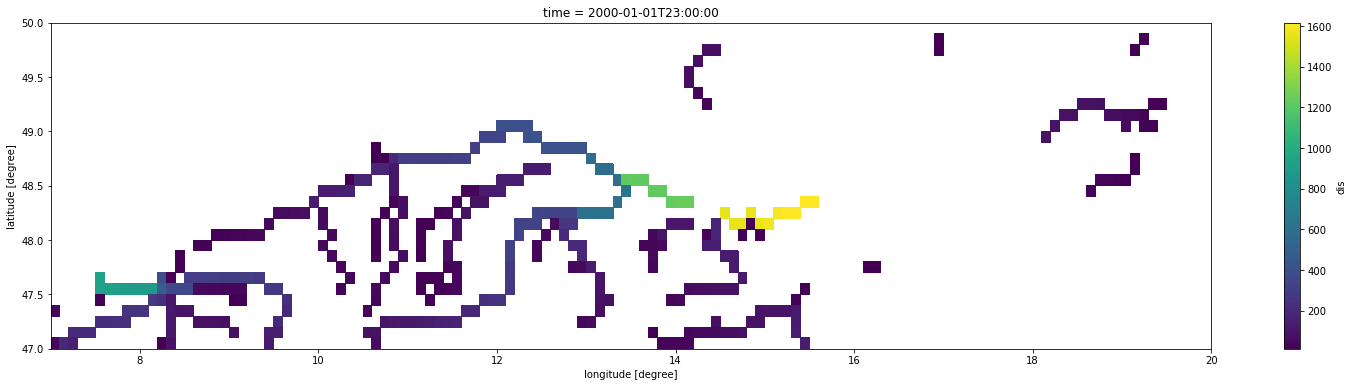

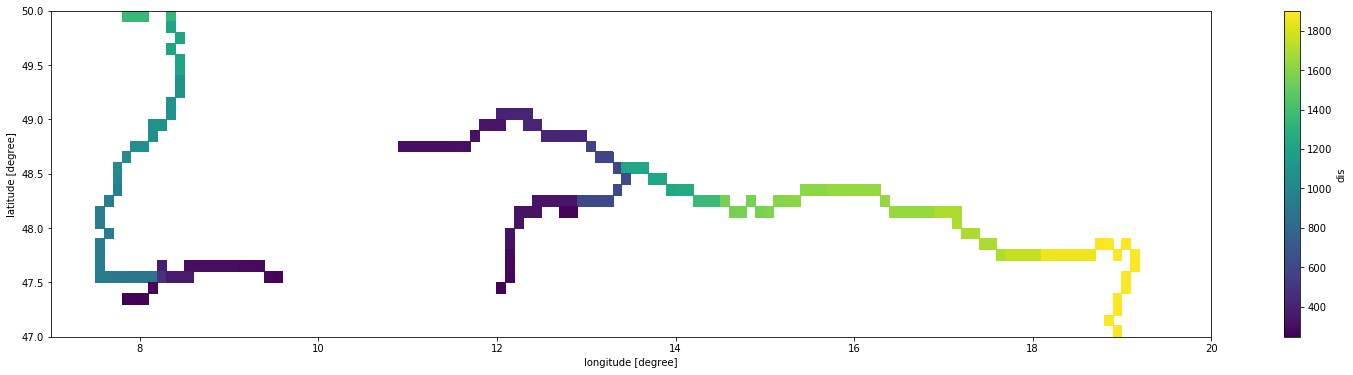

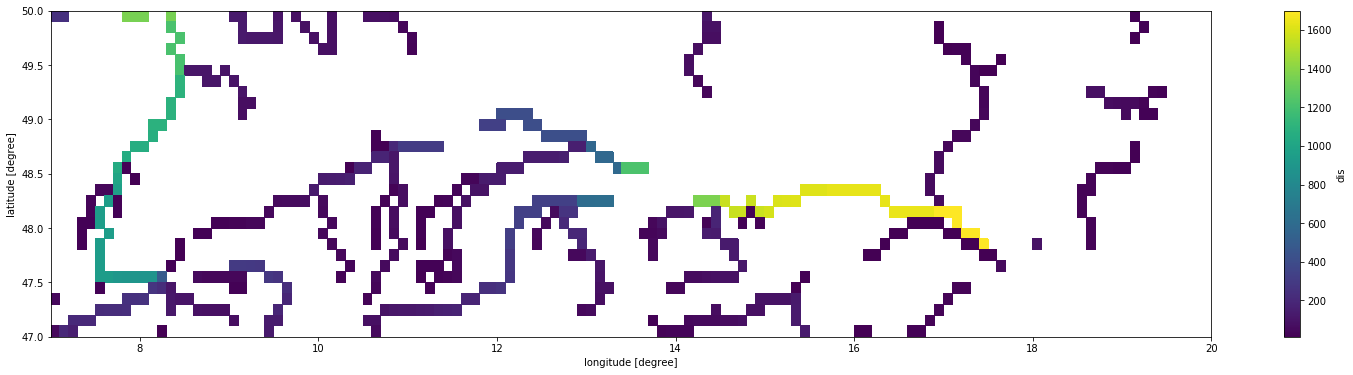

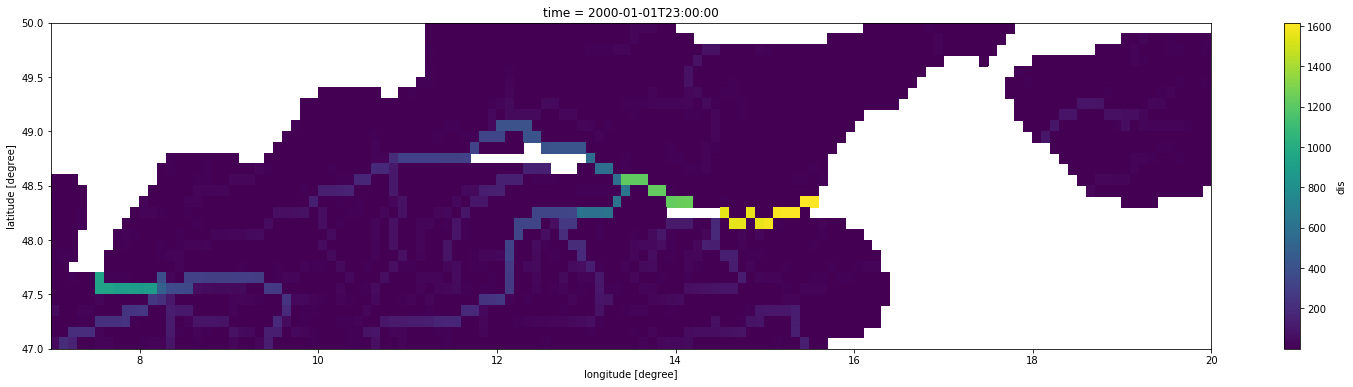

In [320]:
plt.figure(figsize=(26,6))
dis_box_mean.where(mask_box_mean_greater).plot()
plt.figure(figsize=(26,6))
dis_box_mean.where(mask_river_altitude_greater).plot()
plt.figure(figsize=(26,6))
dis_box_mean.where(mask_mean_greater_pct_point).plot()
plt.figure(figsize=(26,6))
dis_box_mean.where(mask_lag_greater).plot()
plt.figure(figsize=(26,6))
dis_box_mean.where(mask_z_greater).plot()

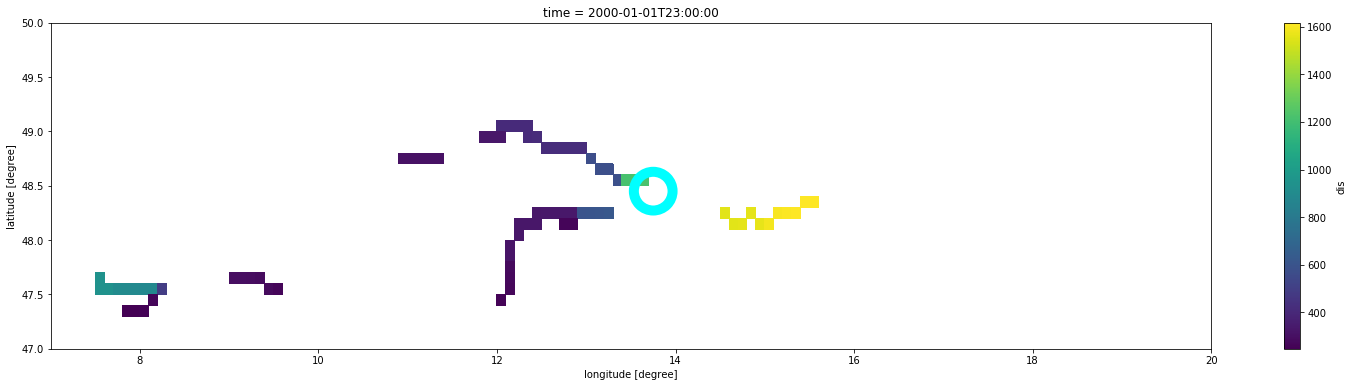

In [333]:
plt.figure(figsize=(26,6))
dis_box_mean.where(mask_box_mean_greater & mask_river_altitude_greater \
                   &mask_lag_greater & mask_z_greater & mask_mean_greater_pct_point).plot()

p = plt.scatter(j, i, s=1500, marker='o', lw=10, facecolor='none', color='cyan')

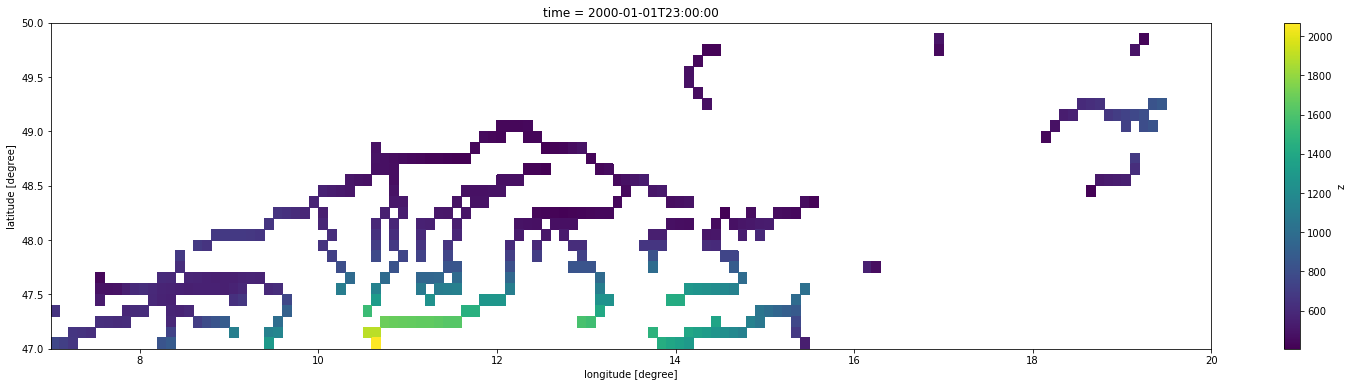

In [334]:
plt.figure(figsize=(26,6))
z_river = z_glofas.where(river)
z_river.where(z_river > z_point.squeeze()-100).plot()

In [117]:
dis_point

<xarray.DataArray 'dis' (time: 8035)>
array([ 795.35077,  789.1969 ,  794.1277 , ..., 1835.7963 , 1871.4622 ,
       1876.7252 ], dtype=float32)
Coordinates:
    latitude   float64 48.45
    longitude  float64 13.75
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2002-12-31
Attributes:
    long_name:  discharge
    units:      m3/s

In [423]:
import geopandas
from rasterio import features
from affine import Affine

def filter_data_inside_single_basin(da, kw_basins='Danube'):
    def transform_from_latlon(lat, lon):
        lat = np.asarray(lat)
        lon = np.asarray(lon)
        trans = Affine.translation(lon[0], lat[0])
        scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
        return trans * scale

    def rasterize(shapes, coords, fill=np.nan, **kwargs):
        """Rasterize a list of (geometry, fill_value) tuples onto the given
        xray coordinates. This only works for 1d latitude and longitude
        arrays.
        """
        transform = transform_from_latlon(coords['latitude'], coords['longitude'])
        out_shape = (len(coords['latitude']), len(coords['longitude']))
        raster = features.rasterize(shapes, out_shape=out_shape,
                                    fill=fill, transform=transform,
                                    dtype=float, **kwargs)
        return xr.DataArray(raster, coords=coords, dims=('latitude', 'longitude'))
    
    # this shapefile is from natural earth data
    # http://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-1-states-provinces/
    shp2 = '/raid/home/srvx7/lehre/users/a1303583/ipython/ml_flood/data/drainage_basins/Major_Basins_of_the_World.shp'
    basins = geopandas.read_file(shp2)
#    print(basins)
    single_basin = basins.query("NAME == '"+kw_basins+"'").reset_index(drop=True)
#    print(single_basin)
    shapes = [(shape, n) for n, shape in enumerate(single_basin.geometry)]

    da['basins'] = rasterize(shapes, da.coords)
    return da.where(da.basins == 0)

In [427]:
z_danube = filter_data_inside_single_basin(z_glofas, kw_basins='Danube')
mask_danube_basin = ~np.isnan(z_danube).astype(bool)

   BASWC4_ID   ID  N    NAME  CONT    NN  FISH_  ACRES         SOURCETHM  \
0         47  472  2  Danube     1  1002     52  0.002  final_draft22.db   

   NO_COUNTRI                        Q3  CHECKED      LAEA_HA   LAEA_ACRES  \
0           0  International catchments       -1  79979269.21  197628774.2   

   LAEA_PRMTR                                           geometry  
0   5898686.2  POLYGON ((18.71999931335449 49.52000045776367,...  


# spatial feature selection

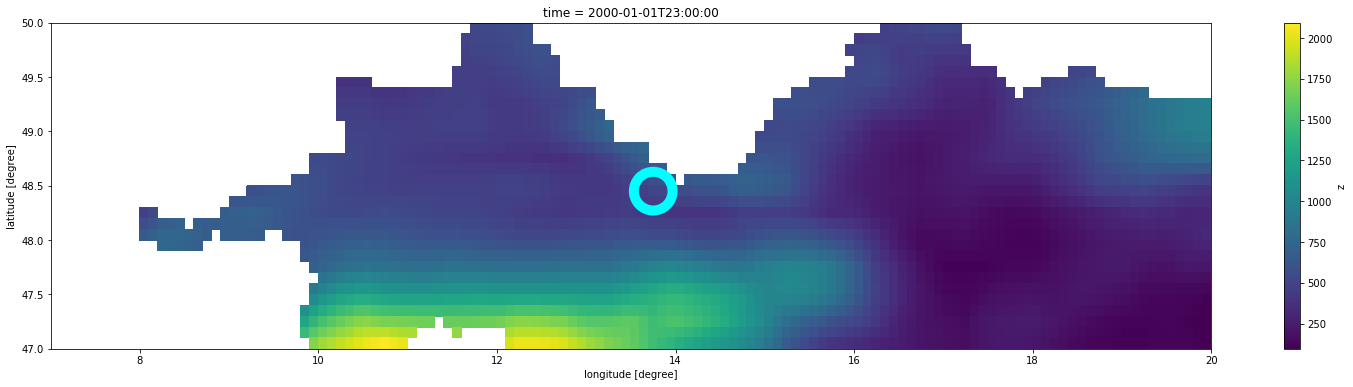

In [388]:
plt.figure(figsize=(26,6))
z_danube.plot()
p = plt.scatter(j, i, s=1500, marker='o', lw=10, facecolor='none', color='cyan')

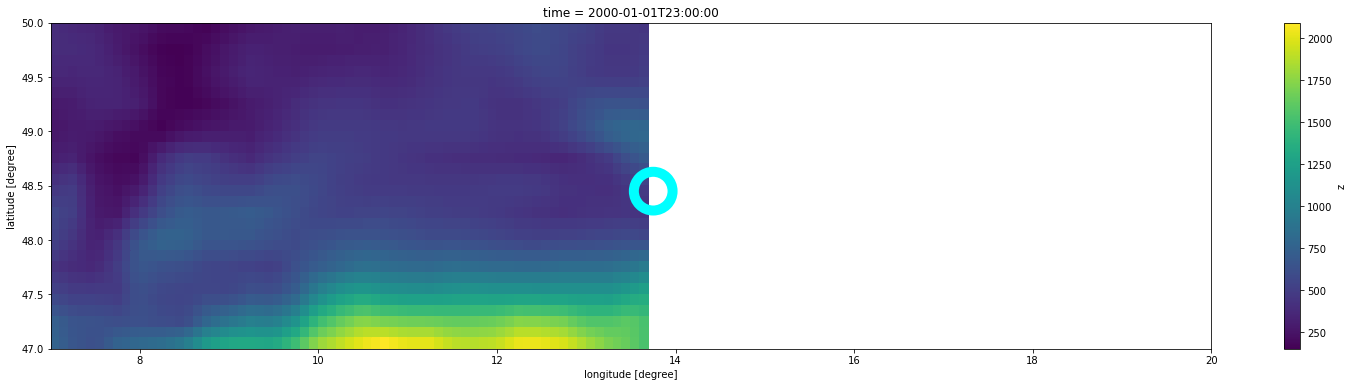

In [400]:
z_downstream = z_glofas.where(z_glofas.longitude <= j)
mask_downstream = ~np.isnan(z_downstream).astype(bool)

plt.figure(figsize=(26,6))
z_glofas.where(mask_downstream).plot()
p = plt.scatter(j, i, s=1500, marker='o', lw=10, facecolor='none', color='cyan')

In [ ]:
z_downstream = z_glofas.where(z_glofas >= z_point.squeeze())
z_downstream = z_downstream.where(z_glofas.longitude >= j)
mask_downstream = ~np.isnan(z_downstream).astype(bool)

plt.figure(figsize=(26,6))
z_glofas.where(mask_downstream).plot()
p = plt.scatter(j, i, s=1500, marker='o', lw=10, facecolor='none', color='cyan')

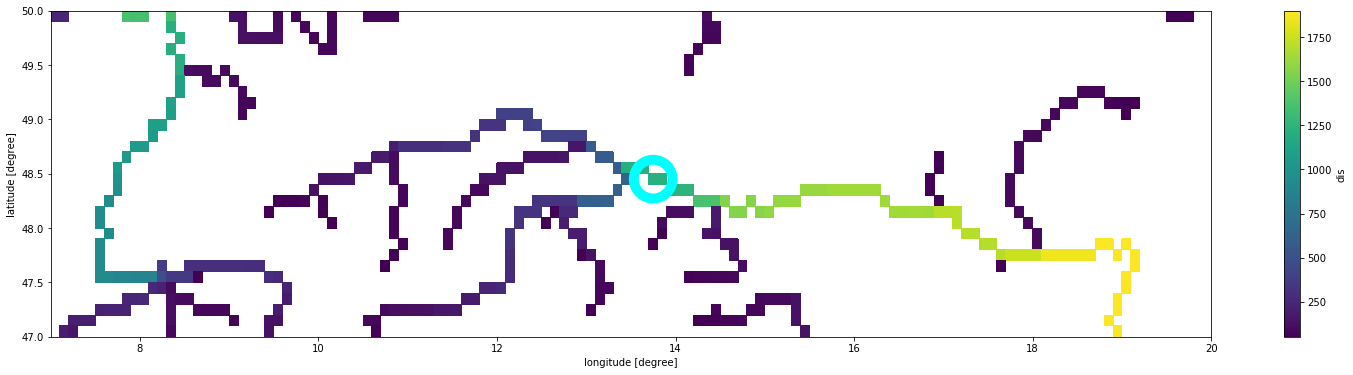

In [397]:
plt.figure(figsize=(26,6))
dis_box_mean.where(mask_box_mean_greater).plot()

p = plt.scatter(j, i, s=1500, marker='o', lw=10, facecolor='none', color='cyan')

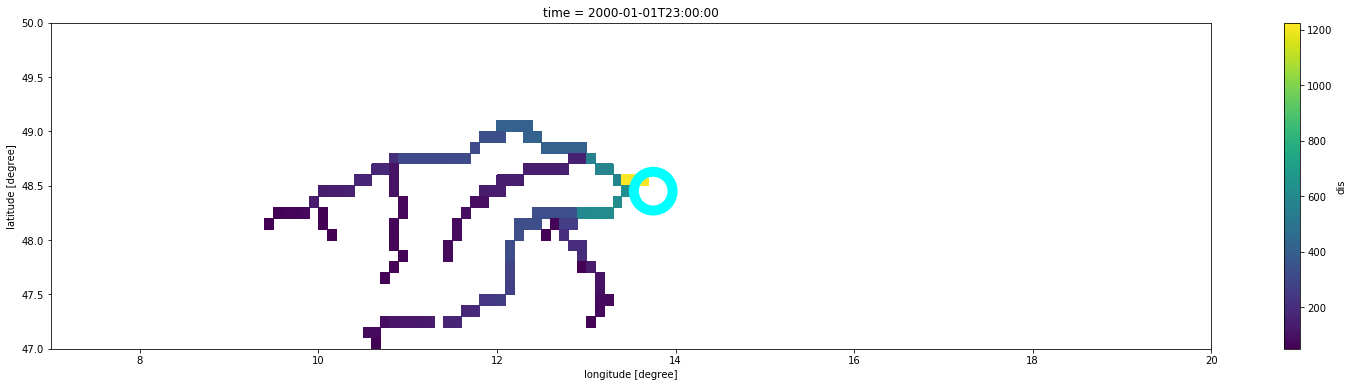

In [398]:
plt.figure(figsize=(26,6))
dis_box_mean.where(mask_box_mean_greater & mask_danube_basin & mask_downstream).plot()

p = plt.scatter(j, i, s=1500, marker='o', lw=10, facecolor='none', color='cyan')

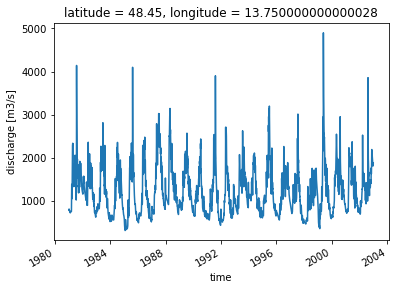

In [406]:
dis_point.plot()

# USA exemplary 

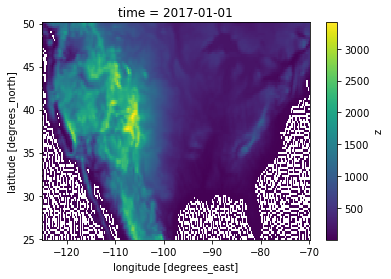

In [433]:
static = xr.open_dataset('../data/usa/era5_slt_z_slor_lsm_stationary_field.nc')
alti = static['z'].isel(time=0)/9.81
glofas = xr.open_dataset('../data/usa/glofas_reanalysis_usa_1981-2002.nc')
glofas = glofas.rename({'lat': 'latitude', 'lon': 'longitude'})  # to have the same name like in era5
glofas = shift_time(glofas, -dt.timedelta(days=1))
z_glofas = static['z'].isel(time=0)/9.81  # converting to m approx.
z_glofas = z_glofas.interp(latitude=glofas.latitude,
                           longitude=glofas.longitude)

alti.where(alti > 0).plot.imshow()

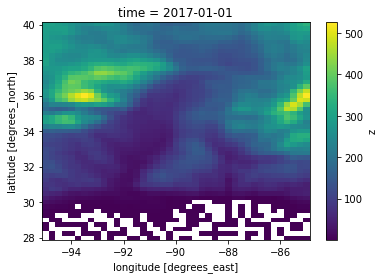

In [430]:
alti = alti.sel(latitude=slice(40, 28), #28, 40),
                    longitude=slice(-95, -85))
alti.where(alti > 0).plot.imshow()
#alti..diff(dim='latitude').plot.imshow()
#(-alti.diff(dim='latitude', n=1)).plot.imshow()
#alti.diff(dim='longitude').plot.imshow()
#(-alti.diff(dim='longitude', n=1)).plot.imshow()

static = xr.open_dataset('../data/danube/era5_slt_z_slor_lsm_stationary_field.nc')
print(static)
alti = static['z'].isel(time=0)/9.81
glofas = xr.open_dataset('../data/danube/glofas_reanalysis_danube_1981-2002.nc')
glofas = glofas.rename({'lat': 'latitude', 'lon': 'longitude'})  # to have the same name like in era5
glofas = shift_time(glofas, -dt.timedelta(days=1))
z_glofas = static['z'].isel(time=0)/9.81  # converting to m approx.
z_glofas = z_glofas.interp(latitude=glofas.latitude,
                           longitude=glofas.longitude)
print(z_glofas)
dis = glofas['dis']
print(dis)




In [438]:
point = (34,-90)
j = -90
i = 34
alti.sel(latitude=point[0], longitude=point[1])

<xarray.DataArray 'z' ()>
array(74.27768, dtype=float32)
Coordinates:
    longitude  float32 -90.0
    latitude   float32 34.0
    time       datetime64[ns] 2017-01-01

In [435]:
z_mississippi = filter_data_inside_single_basin(z_glofas, kw_basins='Mississippi')
mask_mississippi_basin = ~np.isnan(z_mississippi).astype(bool)

   BASWC4_ID  ID   N         NAME  CONT    NN  FISH_  ACRES         SOURCETHM  \
0         50  88  12  Mississippi     5  5012    225  0.008  final_draft22.db   

   NO_COUNTRI                        Q3  CHECKED  LAEA_HA  LAEA_ACRES  \
0           0  International catchments        5      0.0         0.0   

   LAEA_PRMTR                                           geometry  
0         0.0  POLYGON ((-113.4541015625 48.61691665649414, -...  


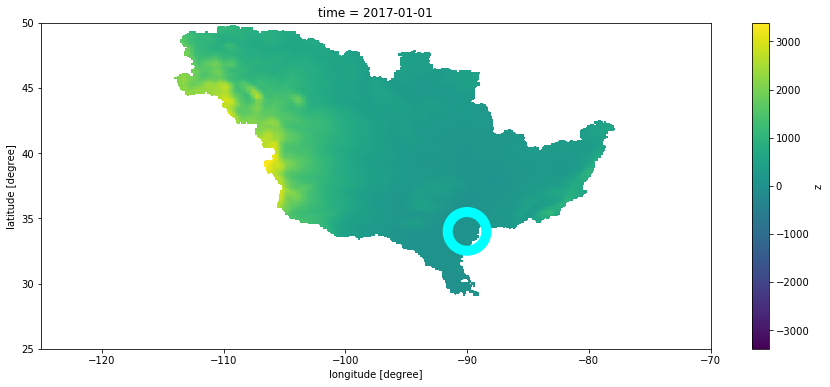

In [448]:
plt.figure(figsize=(15,6))
z_mississippi.plot(cmap='viridis')
p = plt.scatter(j, i, s=1500, marker='o', lw=10, facecolor='none', color='cyan')

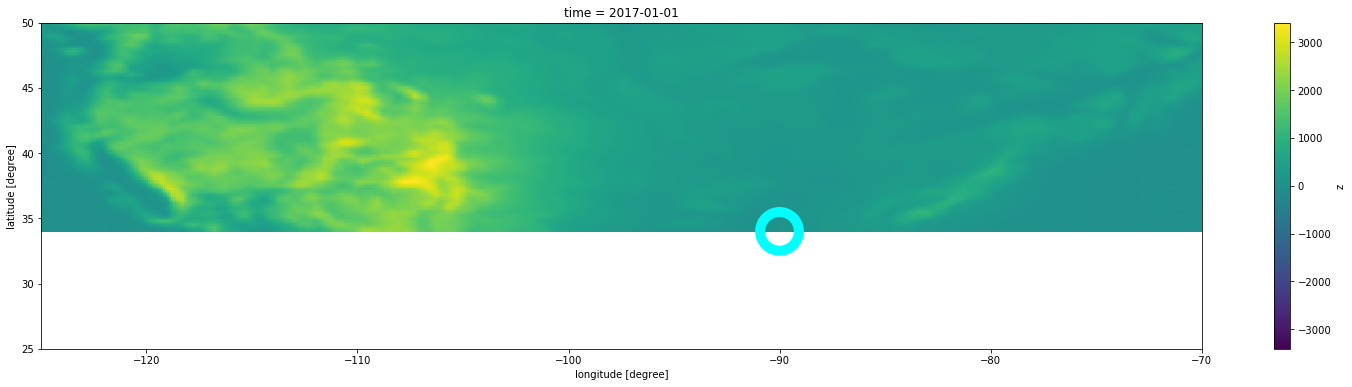

In [449]:
z_downstream = z_glofas.where(z_glofas.latitude >= i)
mask_downstream = ~np.isnan(z_downstream).astype(bool)

plt.figure(figsize=(26,6))
z_glofas.where(mask_downstream).plot(cmap='viridis')
p = plt.scatter(j, i, s=1500, marker='o', lw=10, facecolor='none', color='cyan')

In [454]:
plt.figure(figsize=(26,6))
dis_usa = glofas['dis']
dis_usa_mean = dis_usa.mean('time')
dis_usa_mean.where(dis_usa_mean > 50).plot(cmap='RdBu')

dis_box_mean.where(mask_box_mean_greater).plot(cmap='viridis')

p = plt.scatter(j, i, s=1500, marker='o', lw=10, facecolor='none', color='cyan')

MemoryError: 

<Figure size 1872x432 with 0 Axes>

In [ ]:
plt.figure(figsize=(26,6))
dis_box_mean.where(mask_box_mean_greater & mask_danube_basin & mask_downstream).plot()

p = plt.scatter(j, i, s=1500, marker='o', lw=10, facecolor='none', color='cyan')

In [ ]:
dis_point.plot()

In [452]:
glofas['dis']

<xarray.DataArray 'dis' (time: 8035, latitude: 250, longitude: 550)>
[1104812500 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float64 -124.9 -124.8 -124.7 ... -70.25 -70.15 -70.05
  * latitude   (latitude) float64 49.95 49.85 49.75 49.65 ... 25.25 25.15 25.05
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 2002-12-31
Attributes:
    long_name:  discharge
    units:      m3/s